In [1]:
import os
import sys

os.chdir("../..")

cwd = os.getcwd()

for root, dirs, file in os.walk(cwd):
    sys.path.append(root)

In [2]:
cwd

'c:\\Users\\HP\\Desktop\\Work\\Projects\\factor_investing'

In [3]:
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
from utils import set_layout

In [5]:
%load_ext autoreload
%autoreload 2

## Load Data

#### Ptf infos

In [6]:
PATH_TO_DATA_FACTOR_INFOS = "data/raw_data/factor_cluster_label.csv"

df_ptf_infos = (
    pl.read_csv(PATH_TO_DATA_FACTOR_INFOS).with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
        pl.col("available_date").str.to_date(format="%Y-%m-%d"),
    )
    # .rename({"portfolio": "name", "factor": "cluster"})
)

#### Ptf returns

In [7]:
PATH_TO_DATA_FACTOR_RETURNS = "data/raw_data/us_factors_vw_daily.csv"

df_ptf_rets = (
    pl.read_csv(PATH_TO_DATA_FACTOR_RETURNS)
    .with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
    )
    .join(
        df_ptf_infos.select(["available_date", "portfolio", "factor"]), on="portfolio", how="left"
    )
)

#### Allocation data

In [8]:
PATH_TO_DATA_ALLOCATION = "data/prep_data/alloc/bounded"
ALLOCATION_METHOD = "average"

FILENAMES = (
    pl.DataFrame({"filename": os.listdir(PATH_TO_DATA_ALLOCATION)})
    .filter(pl.col("filename").str.contains(ALLOCATION_METHOD))
    .to_series()
    .sort()
    .to_list()
)

out = []
for filename in FILENAMES:
    out.append(
        pl.read_parquet(os.path.join(PATH_TO_DATA_ALLOCATION, filename))
        .select(["name", "date", "relative_weight", "cluster"])
        .with_columns(pl.lit(filename).alias("alloc_model"))
    )

df_alloc = pl.concat(out)

In [9]:
ALLOC_MODELS_NAMES = df_alloc.select("alloc_model").to_series().unique().sort().to_list()

In [10]:
df_glob_alloc = df_alloc_temp = (
    df_alloc.filter(pl.col("alloc_model") == ALLOC_MODELS_NAMES[0])
    .drop("alloc_model")
    .rename({"relative_weight": f"rw_{ALLOC_MODELS_NAMES[0]}"})
)

for model in tqdm(ALLOC_MODELS_NAMES[1:]):
    df_glob_alloc = df_glob_alloc.join(
        df_alloc.filter(pl.col("alloc_model") == model)
        .drop("alloc_model")
        .rename({"relative_weight": f"rw_{model}"}),
        on=["date", "name", "cluster"],
        how="left",
    )

df_glob_alloc = df_glob_alloc.with_columns(
    pl.sum_horizontal(pl.col("^rw.*$")).truediv(len(ALLOC_MODELS_NAMES)).alias("rw_glob_model")
).select(["date", "name", "cluster", "rw_glob_model"])

100%|██████████| 17/17 [00:00<00:00, 105.93it/s]


## Global Allocation through factors

In [11]:
df_glob_weight_per_factor = (
    df_glob_alloc.group_by(["date", "cluster"])
    .agg(pl.col("rw_glob_model").sum())
    .sort(["date", "cluster"])
)

#### Weight allocate to each factor through T

In [12]:
df_glob_weight_per_factor.plot(
    x="date", y="rw_glob_model", by="cluster", height=350, title="Weight allocate to each factor"
)

:NdOverlay   [cluster]
   :Curve   [date]   (rw_glob_model)

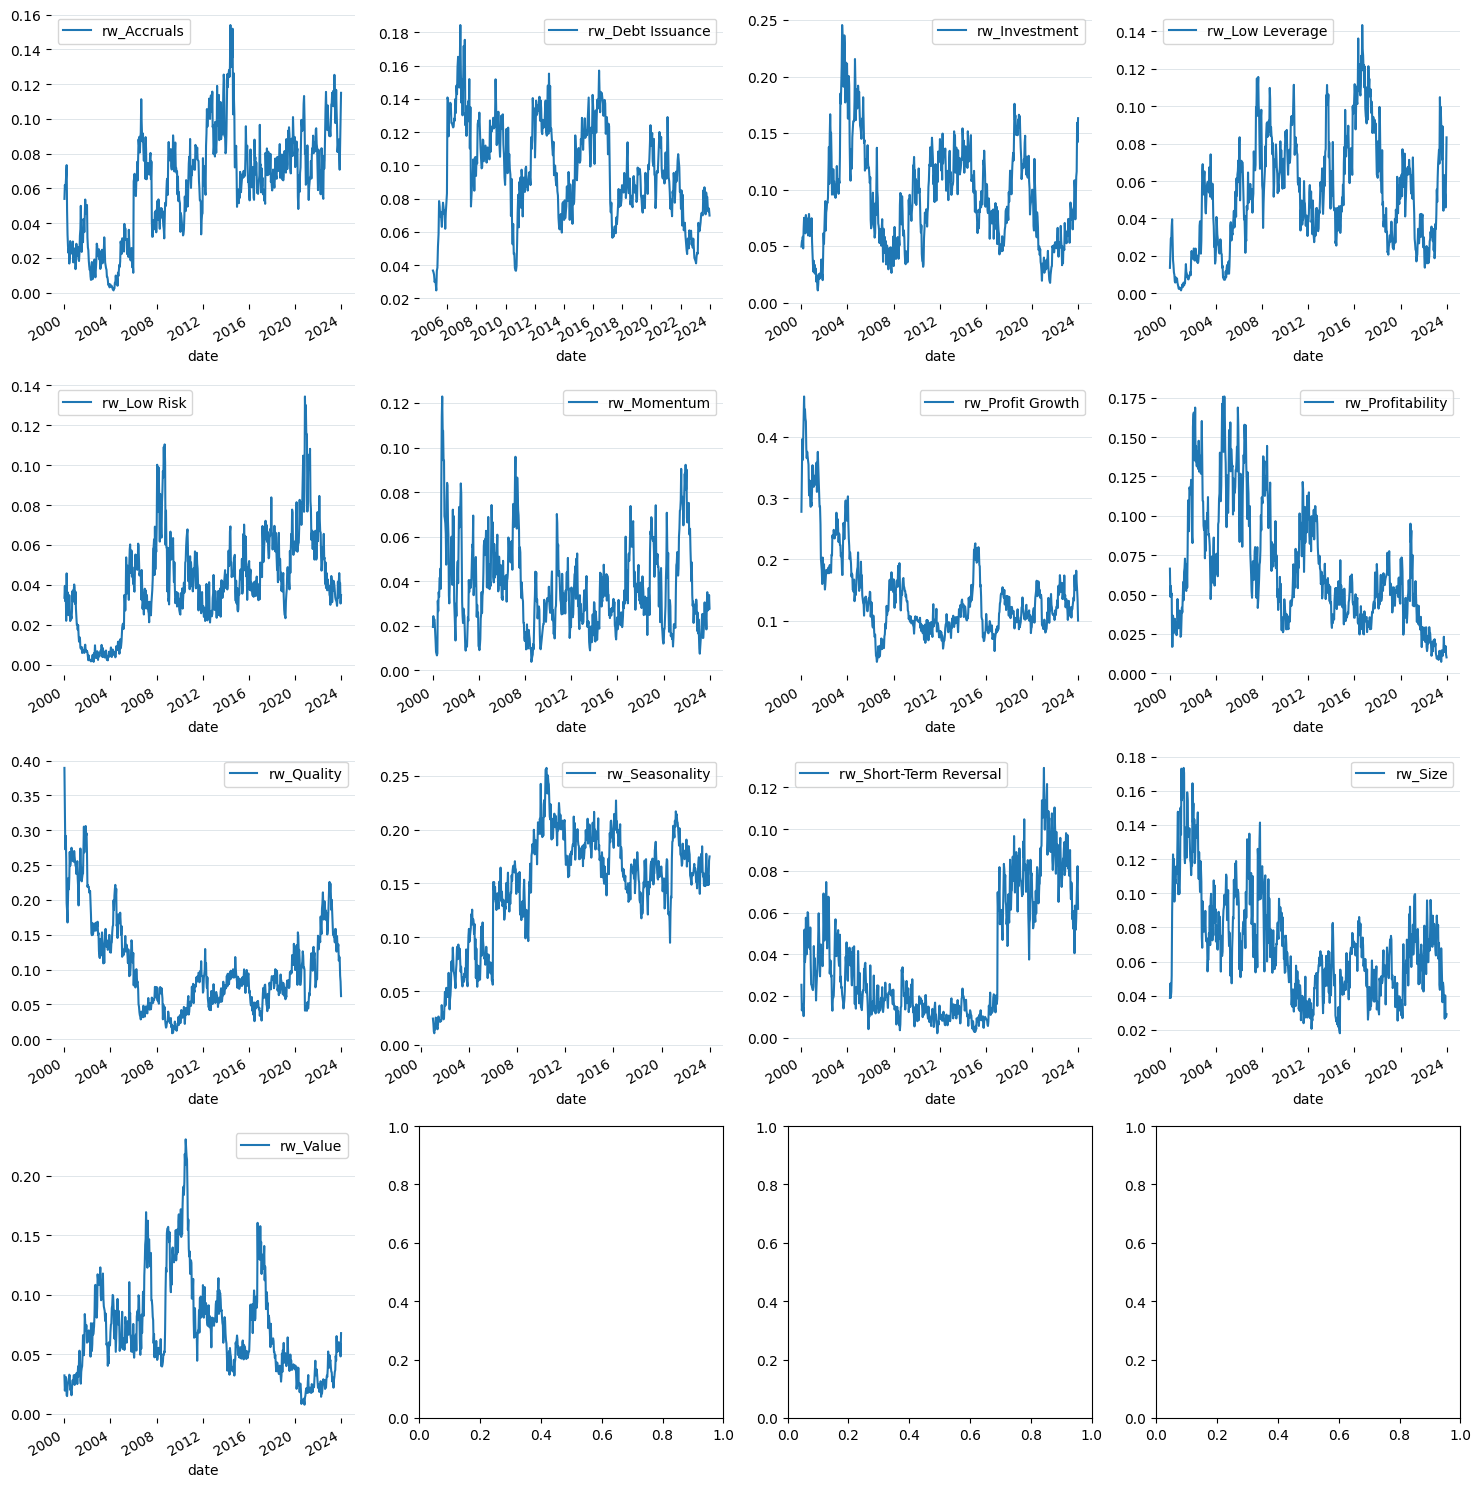

In [13]:
FACTORS = df_glob_weight_per_factor.select("cluster").to_series().unique().sort().to_list()

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))
idx = [(i, j) for i in range(4) for j in range(4)]

for i, factor in enumerate(FACTORS):
    (
        df_glob_weight_per_factor.filter(pl.col("cluster") == factor)
        .select(["date", "rw_glob_model"])
        .rename({"rw_glob_model": f"rw_{factor}"})
        .to_pandas()
        .set_index("date")
        .plot(ax=ax[idx[i]])
    )
    set_layout(ax[idx[i]])
plt.tight_layout()

#### Max weight allocate to one factor

In [14]:
df_glob_weight_per_factor.group_by(["date"]).agg(
    pl.col("rw_glob_model").max().alias("max_weight")
).plot(x="date", y="max_weight", title="Maximum weight allocate to one factor per date")

:Curve   [date]   (max_weight)

## Relative weight change

In [15]:
df_glob_alloc.pivot(index="date", on="name", values="rw_glob_model").with_columns(
    pl.sum_horizontal(pl.all().exclude("date").diff().abs().fill_null(0)).alias("abs_diff_rw")
).select(["date", "abs_diff_rw"]).plot(
    x="date", y="abs_diff_rw", title="Absolute difference of weights change (turnover)"
)

:Curve   [date]   (abs_diff_rw)

In [16]:
df_glob_alloc.pivot(index="date", on="name", values="rw_glob_model").with_columns(
    pl.max_horizontal(pl.all().exclude("date").diff().abs().fill_null(0)).alias("max_abs_diff_rw")
).select(["date", "max_abs_diff_rw"]).plot(
    x="date",
    y="max_abs_diff_rw",
    title="Maximum absolute difference of weights change for one portfolio (turnover)",
)

:Curve   [date]   (max_abs_diff_rw)